In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [5]:
dataset=pd.read_csv('creditcard.csv');
dataset.head();
# dataset.shape;
# dataset.describe();

In [6]:
print("Any nulls in the dataset ", dataset.isnull().values.any())
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ", dataset.Class.unique())

Any nulls in the dataset  False
No. of unique labels  2
Label values  [0 1]


C:\Users\Sanika\AppData\Local\Temp\ipykernel_23204\459402839.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(dataset['Class'], sort=True)


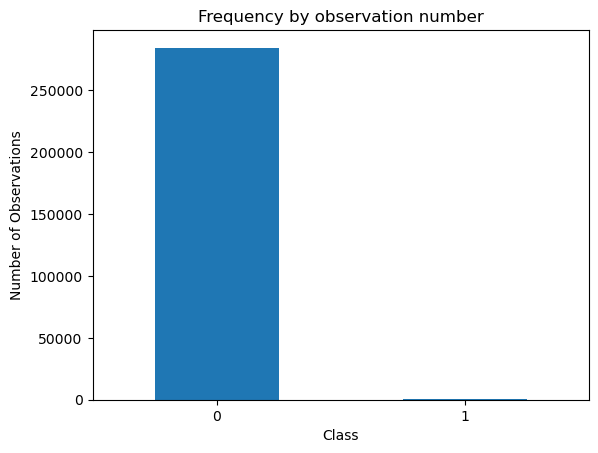

In [7]:
count_classes = pd.value_counts(dataset['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations")
plt.show()

In [8]:
normal_dataset=dataset[dataset['Class']==0]
fraud_dataset=dataset[dataset['Class']==1]
print("Normal dataset shape ", normal_dataset.shape)
print("Fraud dataset shape ", fraud_dataset.shape)


Normal dataset shape  (284315, 31)
Fraud dataset shape  (492, 31)


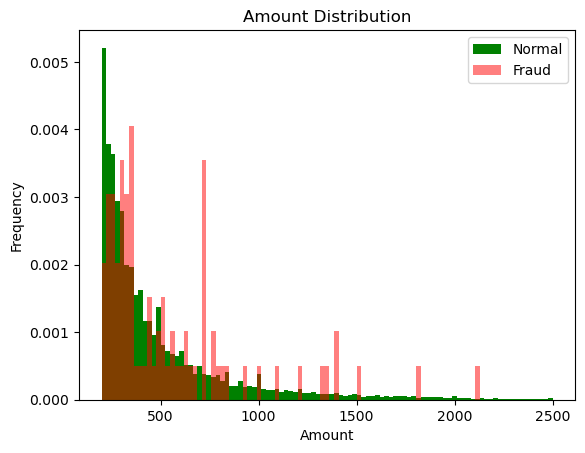

In [9]:
bins=np.linspace(200,2500,100)
plt.hist(normal_dataset['Amount'], bins=bins, color='g', alpha=1,density=True, label='Normal')
plt.hist(fraud_dataset['Amount'], bins=bins, color='r', alpha=0.5,density=True, label='Fraud')
plt.legend(loc='upper right')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution')
plt.show()


In [10]:
sc=StandardScaler()
amount=dataset['Amount'].values
time=dataset['Time'].values
# dataset.drop(['Time','Amount'], axis=1, inplace=True)
dataset['Amount']=sc.fit_transform(amount.reshape(-1,1))
dataset['Time']=sc.fit_transform(time.reshape(-1,1))


In [11]:
raw_data=dataset.values
labels=raw_data[:,-1]
data=raw_data[:,0:-1]

In [12]:
train_data, test_data, train_labels, test_labels=train_test_split(data, labels, test_size=0.2, random_state=2021)
print(train_data.shape, test_data.shape, train_labels.shape, test_labels.shape)


(227845, 30) (56962, 30) (227845,) (56962,)


In [13]:
min_val=tf.reduce_min(train_data)
max_val=tf.reduce_max(train_data)
train_data=(train_data-min_val)/(max_val-min_val)
test_data=(test_data-min_val)/(max_val-min_val)
train_data=tf.cast(train_data, tf.float32)
test_data=tf.cast(test_data, tf.float32)

In [14]:
train_labels=train_labels.astype(bool)
test_labels=test_labels.astype(bool)
print(train_labels.shape)
print(test_labels.shape)

(227845,)
(56962,)


In [15]:
normal_train_data=train_data[~train_labels]
normal_train_labels=train_labels[~train_labels]
fraud_train_data=train_data[train_labels]
fraud_train_labels=train_labels[train_labels]

In [16]:
input_dim=normal_train_data.shape[1]
print(input_dim)

30


In [17]:
encoding_dim=14
hidden_dim_1=int(round(encoding_dim/2))
hidden_dim_2=4
learning_rate=1e-7

In [18]:
input_layer=tf.keras.layers.Input(shape=(input_dim,))
encoder=tf.keras.layers.Dense(units=hidden_dim_1, activation='tanh',
                             activity_regularizer=tf.keras.regularizers.l1(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)


In [19]:
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder = tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

In [20]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.keras", mode='min', monitor='val_loss', verbose=2, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', baseline=None, restore_best_weights=True)
# EarlyStopping: This callback stops training early if the validation loss doesn’t improve after a certain number of epochs.
autoencoder.compile(metrics=['accuracy'], loss='mae', optimizer='adam')


In [21]:
history=autoencoder.fit(normal_train_data, normal_train_data, epochs=50, batch_size=64, shuffle=True, validation_data=(test_data,test_data), callbacks=[cp, early_stop]).history


Epoch 1/50
3550/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0743 - loss: 0.0464
Epoch 1: val_loss improved from inf to 0.00284, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.0743 - loss: 0.0464 - val_accuracy: 0.0078 - val_loss: 0.0028
Epoch 2/50
3546/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0898 - loss: 0.0028
Epoch 2: val_loss improved from 0.00284 to 0.00280, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.0898 - loss: 0.0028 - val_accuracy: 0.0111 - val_loss: 0.0028
Epoch 3/50
3548/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1263 - loss: 0.0028
Epoch 3: val_loss improved from 0.00280 to 0.00278, saving model to autoencoder_fraud.keras
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.1263 - loss: 0.0028 - val_accuracy: 0.2128 - val_loss: 0.0028
Epoch 4/50
3547/3554 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1452 - loss: 0.0028
Epoch 4: val_los

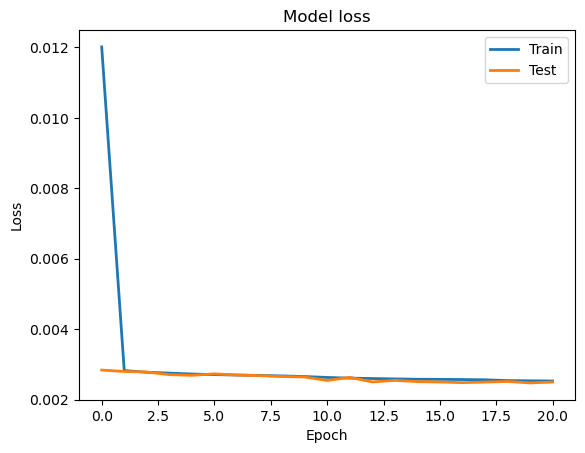

In [22]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [23]:
test_x_prediction=autoencoder.predict(test_data)
test_loss=tf.keras.losses.mse(test_data, test_x_prediction)
test_loss=tf.reshape(test_loss, [-1])

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [24]:
# print(test_loss.shape,test_loss.numpy())
error_df = pd.DataFrame({'Reconstruction_error': test_loss, 'True_class': test_labels})
# true_class_df = error_df[error_df['True_class'] == True]

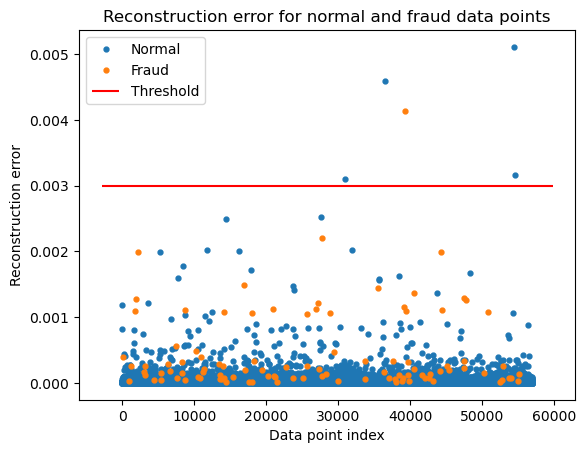

In [25]:
threshold_fixed=0.003
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label="Fraud" if name==1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for normal and fraud data points")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

In [26]:
pred_y=[1 if e>threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred']=pred_y
true_class_df = error_df[error_df['pred'] == 1]
true_class_df

,Reconstruction_error,True_class,pred
31012,0.003095,False,1
36510,0.004589,False,1
39248,0.004142,True,1
54463,0.005109,False,1
54581,0.003166,False,1


[[56855     4]
 [  102     1]]


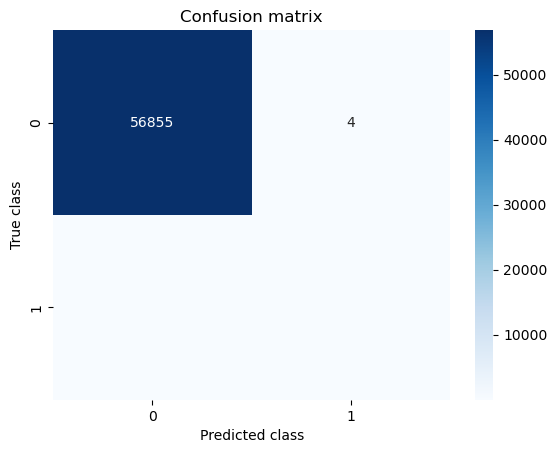

In [27]:
conf_matrix=confusion_matrix(error_df.True_class, pred_y)
print(conf_matrix)
sns.heatmap(conf_matrix,cmap='Blues', annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [28]:
from sklearn.metrics import recall_score, precision_score

print("Accuracy:", accuracy_score(error_df.True_class, pred_y))
print(" Recall: ", recall_score(error_df['True_class'], error_df['pred']))
print(" Precision: ", precision_score(error_df['True_class'], error_df['pred']))

Accuracy: 0.998139110284049
 Recall:  0.009708737864077669
 Precision:  0.2
